# import


In [360]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import itertools
from prophet import Prophet
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima, ARIMA
import matplotlib.pyplot as plt
import holidays
pd.options.plotting.backend = 'plotly'


# data


In [361]:
df_store = pd.read_pickle('data/df_daily.pkl')
df_company = df_store.groupby('date').sum()
train_data = df_company['sales']/1e6
train_data.index.freq = 'D'

In [362]:
train_data.plot(title='Sales TS in Million VND (aggregated data)')

In [363]:
# yearly seasonality
fouri_terms = FourierFeaturizer(365.25, 2)
y_prime, df_fouri = fouri_terms.fit_transform(train_data)
df_fouri.index = y_prime.index

df_fouri.plot()


In [364]:
# holiday
ts_holiday = pd.read_pickle('data/holiday.pkl')
print(ts_holiday.index)

DatetimeIndex(['2018-02-15', '2018-02-16', '2018-02-17', '2018-02-18',
               '2018-02-19', '2018-02-20', '2018-05-01', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-09', '2019-05-01', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-05-01'],
              dtype='datetime64[ns]', name='date', freq=None)


# model


## ARIMA

In [365]:
# combine exog. variables
df_exog = pd.concat([df_fouri, ts_holiday], axis=1)
df_exog['holiday'] = df_exog['holiday'].fillna(False).astype('int')

In [366]:
df_exog.head()

,FOURIER_S365-0,FOURIER_C365-0,FOURIER_S365-1,FOURIER_C365-1,holiday
date,,,,,
2017-08-07,0.017202,0.999852,0.034398,0.999408,0
2017-08-08,0.034398,0.999408,0.068755,0.997634,0
2017-08-09,0.051584,0.998669,0.103031,0.994678,0
2017-08-10,0.068755,0.997634,0.137185,0.990545,0
2017-08-11,0.085906,0.996303,0.171177,0.985240,0


In [856]:
# Split the time series as well as exogenous features data into train and test splits
# steps_ahead = 92 # 3 months
steps_ahead = 14 # 2 weeks
y_to_train = y_prime.iloc[:-steps_ahead]
y_to_test = y_prime.iloc[-steps_ahead:]

exog_to_train = df_exog.iloc[:-steps_ahead]
exog_to_test = df_exog.iloc[-steps_ahead:]

In [320]:
# Fit model to the level to find common order
arima_model = auto_arima(
    y=y_to_train,
    exogenous=exog_to_train,
    D=1, 
    seasonal=True, m=7 # Weekly seasonality
    )
arima_model

KeyboardInterrupt: 

In [321]:
# Forecast
arima_y_fitted = arima_model.predict_in_sample(
    X=exog_to_train)
arima_y_forecast = arima_model.predict(
    n_periods=len(y_to_test), exogenous=exog_to_test)
arima_y_forecast = pd.Series(arima_y_forecast,
                             name='forecast',
                             index=y_to_test.index)

NameError: name 'arima_model' is not defined

In [11]:
# metrics
# in-sample
# mae_IS = round(mean_absolute_error(y_to_train, arima_y_fitted))
# mape_IS = round(mean_absolute_percentage_error(
#     y_to_train, arima_y_fitted), 3)

# out-sample
mae_OOS = round(mean_absolute_error(y_to_test, arima_y_forecast))
mape_OOS = round(mean_absolute_percentage_error(
    y_to_test, arima_y_forecast), 3)

print(f'Company:')
print('Out of sample:',
      f'MAPE: {mape_OOS}',
      f'MAE: {mae_OOS}\n',
      sep='\n')

NameError: name 'arima_y_fitted' is not defined

In [322]:
# print(arima_model)
res_whole_holiday_promo = pd.DataFrame()

In [75]:
# LOOP all stores
for store in df_store['store_id'].unique():  # print(store)
    df_data = df_store[df_store['store_id'] == store].set_index('date')[
        ['sales', 'promo_count']]
    df_data.index.freq = 'D'
    train_data = df_data['sales']/1e6

    # Prepare the fourier terms to model annual seasonality; add as exogenous features to auto_arima
    fouri_terms = FourierFeaturizer(365.25, 2)
    y_prime, df_fouri = fouri_terms.fit_transform(train_data)
    df_fouri.index = y_prime.index

    # combine exog. variables
    df_exog = pd.concat([df_fouri, ts_holiday], axis=1)
    df_exog['holiday'] = df_exog['holiday'].fillna(False).astype('int')
    df_exog.dropna(inplace=True)

    # Split the time series as well as exogenous features data into train and test splits
    y_to_train = y_prime.iloc[:-steps_ahead]
    y_to_test = y_prime.iloc[-steps_ahead:]

    exog_to_train = df_exog.iloc[:-steps_ahead]
    exog_to_test = df_exog.iloc[-steps_ahead:]

    # Fit model to each store in the level
    arima_model_store = ARIMA(
        order=(4, 0, 0),
        seasonal_order=(2, 1, 0, 7),
        # order=arima_model.order,
        # seasonal_order=arima_model.seasonal_order
    ).fit(y_to_train,
          X=exog_to_train
          )

    # Forecast
    # arima_y_fitted = arima_model_store.predict_in_sample(
    #     X=exog_to_train)
    arima_y_forecast = arima_model_store.predict(
        n_periods=len(y_to_test), exogenous=exog_to_test)
    arima_y_forecast = pd.Series(arima_y_forecast,
                                 name='forecast',
                                 index=y_to_test.index)
    # Random walk
    RW_y_forecast = pd.Series(
        y_to_train[-1], name='RW_forecast', index=y_to_test.index)

    # metrics
    # in-sample
    # mae_IS = round(mean_absolute_error(y_to_train, arima_y_fitted))
    # mape_IS = round(mean_absolute_percentage_error(
    #     y_to_train, arima_y_fitted), 3)

    # out-sample
    mae_OOS = round(mean_absolute_error(y_to_test, arima_y_forecast))
    mape_OOS = round(mean_absolute_percentage_error(
        y_to_test, arima_y_forecast), 3)
    RW_mae_OOS = round(mean_absolute_error(y_to_test, RW_y_forecast))
    RW_mape_OOS = round(mean_absolute_percentage_error(
        y_to_test, RW_y_forecast), 3)

    print(f'Store {store}', 
          f'MAPE: {mape_OOS}',
        #   f'MAE: {mae_OOS}\n',
          sep='\n')

    res_whole_holiday_promo = res_whole_holiday_promo.append({
        'store_id': store,
        # 'fc_IS': arima_y_fitted,
        'fc_OOS': arima_y_forecast,
        'fc_RW': RW_y_forecast,
        'arima_mape_OOS': mape_OOS,
        # 'arima_mape_IS': mape_IS,
        'arima_mae_OOS': mae_OOS,
        # 'arima_mae_IS': mae_IS,
        'RW_mape_OOS': RW_mape_OOS,
        'RW_mae_OOS': RW_mae_OOS,
    }, ignore_index=True)

Store 307222
MAPE: 0.428
Store 307244
MAPE: 0.461
Store 307248
MAPE: 0.374
Store 320264
MAPE: 0.52
Store 328165
MAPE: 0.549


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Store 349920
MAPE: 0.507
Store 349924
MAPE: 0.451
Store 349952
MAPE: 0.457
Store 349958
MAPE: 0.448
Store 349962
MAPE: 0.49
Store 349972
MAPE: 0.455


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Store 349978
MAPE: 0.515
Store 349980
MAPE: 0.423
Store 349998
MAPE: 0.396


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Store 350016
MAPE: 0.449
Store 350018
MAPE: 1.338
Store 350026
MAPE: 0.476
Store 350028
MAPE: 0.493
Store 350040
MAPE: 0.503
Store 350046
MAPE: 0.476
Store 350054
MAPE: 0.567
Store 350056
MAPE: 0.516
Store 350060
MAPE: 0.392
Store 354468
MAPE: 0.656
Store 387240
MAPE: 0.475
Store 412585
MAPE: 0.71


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 441997
MAPE: 0.548


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 452387
MAPE: 0.465


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 461349
MAPE: 0.51


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 464495
MAPE: 0.558


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Store 471477
MAPE: 0.421


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 476061
MAPE: 0.607


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 480733
MAPE: 0.49


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 528854
MAPE: 0.386


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 536898
MAPE: 0.628


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 536902
MAPE: 0.895


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Store 566790
MAPE: 1.099


/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Store 566792
MAPE: 0.648


In [76]:
res_whole_holiday_promo.head()

,RW_mae_OOS,RW_mape_OOS,arima_mae_OOS,arima_mape_OOS,fc_OOS,fc_RW,store_id
0,13.0,0.452,13.0,0.428,date 2020-11-01 26.469510 2020-11-02 20....,date 2020-11-01 21.99 2020-11-02 21.99 2...,307222.0
1,10.0,0.454,10.0,0.461,date 2020-11-01 19.930375 2020-11-02 20....,date 2020-11-01 23.4081 2020-11-02 23.40...,307244.0
2,9.0,0.451,7.0,0.374,date 2020-11-01 20.385643 2020-11-02 13....,date 2020-11-01 14.2416 2020-11-02 14.24...,307248.0
3,7.0,0.465,8.0,0.520,date 2020-11-01 19.012270 2020-11-02 13....,date 2020-11-01 14.91545 2020-11-02 14.9...,320264.0
4,41.0,0.594,37.0,0.549,date 2020-11-01 86.226162 2020-11-02 35....,date 2020-11-01 60.16385 2020-11-02 60.1...,328165.0


In [77]:
res_whole_holiday_promo.loc[0, 'fc_OOS']

date
2020-11-01    26.469510
2020-11-02    20.660000
2020-11-03    24.667324
2020-11-04    20.776159
2020-11-05    20.631250
                ...    
2021-01-27    24.564984
2021-01-28    24.088772
2021-01-29    27.625918
2021-01-30    31.919844
2021-01-31    32.793676
Freq: D, Name: forecast, Length: 92, dtype: float64

In [78]:
# res_whole_holiday_promo.to_pickle('results/res_RW_ARIMA_whole_holiday_promo.pkl')
# res_whole_holiday_promo = pd.read_pickle('results/res_RW_ARIMA_whole_holiday_promo.pkl')

## FB Prophet

In [325]:
fb_df = pd.concat([df_company[['sales']], ts_holiday], axis=1)
fb_df['sales'] = fb_df['sales']/1e6
fb_df['holiday'] = fb_df['holiday'].fillna(False).astype('bool')
fb_df = fb_df.reset_index().rename({'date': 'ds', 'sales': 'y'}, axis=1)
fb_train = fb_df.iloc[:-steps_ahead]
fb_test = fb_df.iloc[-steps_ahead:]

In [83]:
# Grid search set up
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]

In [90]:
mape_PROPHET = []
for params in all_params:
    # set up model
    m = Prophet(**params)
    m.add_regressor('holiday')
    m.fit(fb_train)
    # set up CV
    df_cv = cross_validation(
        m,
        initial=(str(fb_train.shape[0]-steps_ahead*2)+' days'),
        period=(str(steps_ahead)+' days'),
        horizon=(str(steps_ahead)+' days'),
        )
    # evaluate
    df_p = performance_metrics(df_cv)
    mape_PROPHET.append(df_p['mape'].values[-1])


# result
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape_PROPHET
tuning_results = tuning_results.sort_values('mape').reset_index(drop=True)
tuning_results


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2456.13   7.41044e-07       5103.42      0.1444      0.6373      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       2456.22   4.54406e-09       4993.58       0.358       0.358      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2241.65   1.66047e-08       4456.34      0.4385      0.4385      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       2241.65    7.7757e-09       4287.14      0.6344      0.6344      133   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2472.49   5.42606e-07       4753.63      0.7116      0.7116      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2472.49   3.04346e-09       4782.58      0.3759      0.3759      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2268.41   5.37755e-07       4810.69      0.1865           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       2268.41   9.16244e-09       4887.91       0.162      0.5315      131   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2476.88   6.05393e-08       4896.71      0.1452      0.4634      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       2476.88   5.37966e-09       4650.57      0.2391      0.2391      141   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2267.13   3.68721e-07       4222.44           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       2267.13   5.18383e-09       4357.23      0.2711      0.2711      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2477.7   1.30368e-06       4944.85      0.8601      0.8601      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       2477.71   2.28517e-09        4832.4      0.2266      0.2266      148   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       2266.77   8.88028e-05       5012.92   1.779e-08       0.001      120  LS failed, Hessian reset 
      99       2267.03   2.36758e-07        3765.5      0.7137      0.7137      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       2267.04    2.8479e-07       4099.96    5.35e-11       0.001      229  LS failed, Hessian reset 
     129       2267.04   3.35296e-09       4932.26     0.09859     0.09859      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       2476.46   0.000257979        363.16   8.391e-07       0.001      123  LS failed, Hessian reset 
      94       2476.51   2.19542e-06       302.002   6.562e-09       0.001      210  LS failed, Hessian reset 
      99       2476.51   6.65741e-07       266.601           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       2476.51   5.94914e-09       284.761     0.08385      0.4072      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       2274.98   3.51794e-06       337.643   1.957e-08       0.001      153  LS failed, Hessian reset 
      99       2274.98   9.72082e-08        290.25      0.3475      0.8578      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       2274.98   9.64331e-07       311.228   2.508e-09       0.001      240  LS failed, Hessian reset 
     127       2274.98   3.58662e-08       227.095      0.5812      0.5812      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.91s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       2501.32   7.24861e-05       274.906   2.031e-07       0.001       97  LS failed, Hessian reset 
      84       2501.37    5.5003e-05       301.956   2.081e-07       0.001      185  LS failed, Hessian reset 
      99       2501.38   2.64691e-05       302.071       2.838      0.2838      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       2501.39   3.88397e-06       300.815   1.151e-08       0.001      287  LS failed, Hessian reset 
     157        2501.4   1.71931e-06       247.312   6.365e-09       0.001      369  LS failed, Hessian reset 
     175        2501.4   5.03457e-08       233.468           1           1      392   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       2300.34   0.000537766       293.757   1.268e-06       0.001       88  LS failed, Hessian reset 
      61        2300.4   2.69438e-06       254.136   1.113e-08       0.001      149  LS failed, Hessian reset 
      84       2300.42   3.56821e-05       351.074   1.328e-07       0.001      219  LS failed, Hessian reset 
      99       2300.42   2.66308e-07       274.084           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       2300.49   5.82868e-05       316.384   1.449e-07       0.001      328  LS failed, Hessian reset 
     194       2300.53   4.21425e-08       272.583      0.2238           1      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2501.68   4.15973e-07       263.418      0.2783           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       2501.68    2.3393e-08       308.501      0.3671      0.9087      181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2300.91   9.26995e-07       344.407      0.6862      0.6862      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2300.97   5.86543e-05        362.44       4.933           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2301.23   7.80819e-08       218.713      0.4214           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       2301.23   5.07717e-06       291.544   1.768e-08       0.001      472  LS failed, Hessian reset 
     343       2301.23   6.07434e-09       266.827     0.04422      0.9142      507   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.02s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36        2501.6   8.58295e-05        215.85   2.791e-07       0.001       82  LS failed, Hessian reset 
      83       2501.67   6.17247e-06        338.11   2.678e-08       0.001      189  LS failed, Hessian reset 
      99       2501.67   2.61185e-06       365.829           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       2501.81   0.000108661       276.603   2.988e-07       0.001      352  LS failed, Hessian reset 
     199       2501.83   7.14398e-07       258.923           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       2501.84   2.75605e-08       305.228      0.3226           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2300.9   1.64031e-06       333.218      0.1444      0.1444      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       2301.02   6.98484e-06       364.925    2.05e-08       0.001      286  LS failed, Hessian reset 
     190       2301.02   4.14473e-08       181.593       0.341           1      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2500.58   0.000309784       34.5369      0.4193           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       2501.12   0.000921317       130.616   2.597e-05       0.001      220  LS failed, Hessian reset 
     199       2501.21    0.00141184       57.8975       0.214           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       2501.26   4.13265e-07        37.527      0.7708      0.7708      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2297.63    0.00522821       62.9626           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       2297.67   0.000195392       64.6604   2.453e-06       0.001      160  LS failed, Hessian reset 
     176       2297.94    4.6185e-05       38.3552   1.232e-06       0.001      299  LS failed, Hessian reset 
     199       2297.94   1.08979e-05       36.7402           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       2297.95   4.83367e-05       26.6995   1.269e-06       0.001      416  LS failed, Hessian reset 
     275       2297.95   1.15153e-06       28.4647           1           1      484   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

100%|██████████| 1/1 [00:02<00:00,  2.12s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2525.99   5.93781e-05       38.7775      0.2866      0.2866      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       2526.65    0.00014044        55.346   1.779e-06       0.001      296  LS failed, Hessian reset 
     199       2526.69   0.000765113       50.0481           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265        2526.8   2.93799e-07        33.822           1           1      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2323.19     0.0016475       58.1296           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2323.73    0.00132212       48.4446           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       2323.92   0.000252672       75.7037   5.521e-06       0.001      322  LS failed, Hessian reset 
     294       2323.97    3.7378e-05       37.5535   8.464e-07       0.001      432  LS failed, Hessian reset 
     299       2323.97   3.13307e-06       35.6754      0.2323      0.2323      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       2323.97   3.67611e-07       28.5184      0.2028      0.5093      458   
Optimization terminat

100%|██████████| 1/1 [00:01<00:00,  1.92s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2526.33   0.000989604       45.3454           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       2526.63   0.000146329        55.213   1.985e-06       0.001      192  LS failed, Hessian reset 
     199       2526.93    0.00853608       73.2042      0.3718           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       2526.97   0.000942501       68.6496    1.43e-05       0.001      323  LS failed, Hessian reset 
     299       2527.11   2.72888e-06       34.3931           1           1      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304       2527.11   6.52752e-06       39.7346   1.608e-07       0.001      492  LS failed, Hessian reset

Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2323.38   0.000791514       48.5035        0.24      0.7354      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       2324.02    0.00030577       66.5315   7.452e-06       0.001      227  LS failed, Hessian reset 
     187       2324.04   1.26253e-05       37.6615   3.396e-07       0.001      320  LS failed, Hessian reset 
     199       2324.04   6.16293e-07       39.3573      0.9676      0.2755      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       2324.04   2.35394e-07       31.7761     0.01207           1      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2526.39   0.000246988       57.0866       0.503       0.503      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       2526.81    0.00012714       45.8368   2.985e-06       0.001      251  LS failed, Hessian reset 
     199       2526.82   9.66991e-07       34.7809       0.313      0.9699      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       2526.82   1.08225e-07       35.2321      0.2461           1      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2323.8      0.010376       212.928      0.6574           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       2324.05   4.42188e-05        36.401   1.221e-06       0.001      231  LS failed, Hessian reset 
     170       2324.05   8.52136e-08       42.6762      0.2103           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2508.53    0.00161878       24.9529           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2512.02     0.0057884       28.5412           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2513.34     0.0023119       33.7896      0.6246      0.6246      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2514.36   0.000598677       38.4545           1           1      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2514.63    0.00129417       13.0491           1           1      601   
    Iter      log prob        ||dx||      ||grad||       alpha   

Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2302.8    0.00253295       40.7357           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2304.03    0.00405208       23.5301           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2304.64    0.00374915       11.9742           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       2304.71   6.54483e-05       11.1087   1.467e-06       0.001      426  LS failed, Hessian reset 
     379        2304.8    5.5369e-05       10.2389   1.475e-06       0.001      545  LS failed, Hessian reset 
     399       2304.81   5.27989e-05       6.67157           1           1      567   
    Iter      log pro

100%|██████████| 1/1 [00:02<00:00,  2.55s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2535.08   0.000799676       38.3559      0.5302      0.5302      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2536.84     0.0142476       116.029           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2537.83    0.00146231       10.2191           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2538.28   0.000268792       16.4521      0.1368           1      469   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2538.4     0.0126723       19.9761           1           1      589   
    Iter      log prob        ||dx||      ||grad||       alpha   

Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2328.56     0.0106786       133.842      0.2382           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2330.92      0.012599       34.9832           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2331.2    0.00202043       24.0172           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     321        2331.3   0.000268387       32.8312   2.718e-05       0.001      403  LS failed, Hessian reset 
     379       2331.42   8.49852e-05       15.8094   7.972e-06       0.001      515  LS failed, Hessian reset 
     399       2331.42    0.00030537       6.14662           1           1      539   
    Iter      log pro

100%|██████████| 1/1 [00:02<00:00,  2.48s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2535.1    0.00404029       158.837      0.3887      0.3887      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2537.17   0.000566808       17.6468      0.3908      0.3908      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2537.7    0.00584842        40.081           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2538.36    0.00253113         18.31           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     406       2538.37   3.87074e-05       13.4951   1.745e-06       0.001      511  LS failed, Hessian reset 
     499       2538.59    0.00224151     

 log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     871       2538.78   5.66979e-05       17.5846    6.47e-06       0.001     1290  LS failed, Hessian reset 
     899       2538.79   6.34877e-05       7.51086           1           1     1324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     924       2538.79   6.93367e-06       5.81726   9.506e-07       0.001     1403  LS failed, Hessian reset 
     929       2538.79   1.22664e-06       6.51431      0.2207           1     1409   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2328.78   0.000311611       50.7148      0.1814      0.1814      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       

100%|██████████| 1/1 [00:02<00:00,  2.35s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2020-07-31 00:00:00 and 2020-07-31 00:00:00


Initial log joint probability = -8.2067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2535.31     0.0029917       69.5246           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2537.26     0.0130673       86.7031           1           1      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2537.88    0.00131186       14.9721           1           1      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     386       2538.26   9.35052e-05       20.9288   5.706e-06       0.001      492  LS failed, Hessian reset 
     399       2538.28    0.00164712       10.2525      0.3426           1      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     410        2538.3   6.58474e-05     

Initial log joint probability = -10.8767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2328.86     0.0058581       30.1359           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2331.24   0.000806484       64.6834      0.2925      0.2925      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       2331.38   4.99932e-05       14.8747   1.788e-06       0.001      332  LS failed, Hessian reset 
     299       2331.51   8.13314e-05        8.3229      0.5611      0.5611      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2331.67     0.0121779       6.02354       0.904           1      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     401       2331.67   8.69848e-05    

100%|██████████| 1/1 [00:02<00:00,  2.66s/it]


In [105]:
# final PROPHET
fb_model = Prophet(
    changepoint_prior_scale=tuning_results.loc[0, 'changepoint_prior_scale'],
    seasonality_prior_scale=tuning_results.loc[0, 'seasonality_prior_scale'],
)

fb_model.fit(fb_df)
fb_fc = fb_model.predict(fb_test)
mape_PROPHET = round(mean_absolute_percentage_error(fb_test['y'], fb_fc['yhat']), 3)
mape_PROPHET

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.0885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2660.69   8.83443e-07       4586.67      0.5836      0.5836      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       2660.71   8.10305e-07       4933.35   1.748e-10       0.001      223  LS failed, Hessian reset 
     151       2660.71    8.0074e-09       4188.87      0.1957      0.1957      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


0.326

In [106]:
res_fb = pd.DataFrame()
# LOOP all stores
for store in df_store['store_id'].unique():  # print(store)
    df_data = df_store[df_store['store_id'] == store].set_index('date')[
        ['sales']]
    fb_df = pd.concat([df_data, ts_holiday], axis=1)
    fb_df['sales'] = fb_df['sales']/1e6
    fb_df['holiday'] = fb_df['holiday'].fillna(False).astype('bool')
    fb_df = fb_df.dropna().reset_index().rename(
        {'date': 'ds', 'sales': 'y'}, axis=1)
    fb_train = fb_df.iloc[:-steps_ahead]
    fb_test = fb_df.iloc[-steps_ahead:]

    fb_model = Prophet(
        changepoint_prior_scale=tuning_results.loc[0,'changepoint_prior_scale'],
        seasonality_prior_scale=tuning_results.loc[0,'seasonality_prior_scale'],
    )
    fb_model.add_regressor('holiday')
    fb_model.fit(fb_train)
    fb_fc = fb_model.predict(fb_test)

    # metrics
    fb_mae_OOS = round(mean_absolute_error(fb_test['y'], fb_fc['yhat']))
    fb_mape_OOS = round(mean_absolute_percentage_error(
        fb_test['y'], fb_fc['yhat']), 3)

    print(f'Store {store}')
    print(f'MAPE: {fb_mape_OOS}',
          f'MAE: {fb_mae_OOS}\n',
          sep='\n')

    res_fb = res_fb.append({
        'store_id': store,
        'fb_fc': fb_fc['yhat'],
        'fb_mape_OOS': fb_mape_OOS,
        'fb_mae_OOS': fb_mae_OOS,
    }, ignore_index=True)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.54053
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2523.38   9.64828e-07        5092.5      0.3498           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       2523.44   4.00178e-06       5059.71   7.933e-10       0.001      189  LS failed, Hessian reset 
     138       2523.46   1.34002e-06       5077.97   2.629e-10       0.001      249  LS failed, Hessian reset 
     158       2523.47   4.98696e-09       4987.86      0.3865      0.3865      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 307222
MAPE: 0.454
MAE: 14

Initial log joint probability = -8.42503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2375.85   1.63755e-05       5089.27      0.8049      0.8049      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       2375.93   1.31589e-07       5043.41   2.625e-11       0.001      227  LS failed, Hessian reset 
     152       2375.93   6.56576e-09       4944.56      0.3922      0.3922      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 65%|██████▍   | 33/51 [12:55<07:03, 23.50s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 307244
MAPE: 0.452
MAE: 11

Initial log joint probability = -6.98364
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2387.23   1.37842e-06          5034   2.838e-10       0.001      160  LS failed, Hessian reset 
      99       2387.23   2.57552e-07       5130.48      0.1966           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       2387.23   8.57508e-09        5302.2      0.7573      0.7573      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 307248
MAPE: 0.382
MAE: 7

Initial log joint probability = -4.88837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2742.81   0.000470626       4993.33      0.6863      0.6863      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       2743.82   6.21107e-09       5008.24      0.4369      0.4369      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 320264
MAPE: 0.492
MAE: 7

Initial log joint probability = -8.27071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2418.61   2.03624e-07       4601.15      0.3882      0.3882      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       2418.61   7.41035e-09       4717.57      0.3479      0.3479      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 328165
MAPE: 0.488
MAE: 33

Initial log joint probability = -12.6077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2180.45   4.42977e-07       5035.81      0.4137           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2180.45   4.25408e-09       4459.44      0.2162      0.2162      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349920
MAPE: 0.433
MAE: 18

Initial log joint probability = -6.77403
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2386.08   1.03264e-05       5526.63      0.4576      0.4576      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2389.59   4.73041e-05       5670.44           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        2389.6   9.10323e-06       4559.72   1.605e-09       0.001      284  LS failed, Hessian reset 
     245       2389.64   1.35853e-06       4433.09   2.645e-10       0.001      379  LS failed, Hessian reset 
     268       2389.64   9.57849e-09       4536.48      0.3026      0.3026      410   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349924
MAPE: 0.521
MAE: 12

Initial log joint probability = -5.95207
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2591.69   3.75808e-07       4948.69      0.4772      0.4772      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       2591.69   3.61089e-07       4963.29    7.16e-11       0.001      184  LS failed, Hessian reset 
     129       2591.69   5.85593e-09       5074.69      0.2949           1      223   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349952
MAPE: 0.376
MAE: 8

Initial log joint probability = -7.62978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2364.46    2.3735e-05       4824.05           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       2364.53   9.36652e-09       4974.85           1           1      173   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349958
MAPE: 0.384
MAE: 11

Initial log joint probability = -7.66767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2379.76   5.04615e-06       5679.34       3.552      0.3552      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       2379.81    4.5846e-06       3971.84   8.972e-10       0.001      184  LS failed, Hessian reset 
     125       2379.84   9.13279e-09       5019.31     0.04815     0.04815      210   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349962
MAPE: 0.501
MAE: 8

Initial log joint probability = -6.31388
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2475.32   7.27882e-05       3725.98      0.5136      0.5136      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       2488.95   5.92386e-09       5171.62      0.2206           1      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349972
MAPE: 0.397
MAE: 10

Initial log joint probability = -6.86319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       2345.84   8.42182e-09       4800.34      0.7772      0.7772      109   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349978
MAPE: 0.501
MAE: 6

Initial log joint probability = -9.43007
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2252.9    0.00307433       5231.11           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       2257.68   5.87074e-09       4918.95      0.3436      0.7998      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349980
MAPE: 0.324
MAE: 9

Initial log joint probability = -6.81927
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2421.28    2.8708e-06       4611.16           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       2421.65   4.27495e-05       4915.62   8.309e-09       0.001      226  LS failed, Hessian reset 
     167       2422.26   2.93798e-09       5147.93      0.2886      0.2886      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349998
MAPE: 0.478
MAE: 7

Initial log joint probability = -15.0287
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2048.3   5.65441e-06       4920.42           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       2048.32   8.44796e-09       4896.26      0.2029           1      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350016
MAPE: 0.304
MAE: 6

Initial log joint probability = -8.27129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       2521.82    4.5985e-09       4661.28      0.2183      0.2183       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350018
MAPE: 0.711
MAE: 34

Initial log joint probability = -10.0119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       2230.75   0.000305859       4799.03   5.959e-08       0.001      136  LS failed, Hessian reset 
      99       2231.97   1.60393e-05       5844.82     0.01722           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       2232.11   7.20544e-09       4652.58      0.1744      0.1744      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350026
MAPE: 0.548
MAE: 5

Initial log joint probability = -9.27233
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86        2155.9   2.33402e-05       5060.55   4.877e-09       0.001      158  LS failed, Hessian reset 
      99       2155.96    5.4371e-07       4518.24      0.4471      0.4471      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       2155.97   8.56661e-09       4335.86      0.6686      0.6686      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350028
MAPE: 0.572
MAE: 6

Initial log joint probability = -8.57007
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2317.12   0.000174687       5029.99           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2329.07   1.10186e-05       4683.81      0.2836           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       2329.21   6.84436e-06       4852.86   1.327e-09       0.001      314  LS failed, Hessian reset 
     252       2329.24   7.51333e-09       4701.68      0.2511      0.2511      351   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350040
MAPE: 0.471
MAE: 9

Initial log joint probability = -11.3503
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1982.17   0.000421326        5027.9           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       1982.64    8.2039e-09       4860.74      0.3049      0.3049      164   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350046
MAPE: 0.464
MAE: 4

Initial log joint probability = -7.0212
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       2348.73   1.95799e-09       4479.13      0.1547      0.1547      107   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350054
MAPE: 0.568
MAE: 13

Initial log joint probability = -12.8359
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2001.96    0.00697737       4947.35           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2019.42   5.29639e-07       4266.01      0.1137      0.3675      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       2019.55   6.82715e-06        4467.8   1.608e-09       0.001      335  LS failed, Hessian reset 
     269       2019.58   9.59058e-09       5183.98      0.8286      0.8286      374   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350056
MAPE: 0.468
MAE: 3

Initial log joint probability = -6.67062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2454.91   8.59227e-05       4950.35      0.3301      0.3301      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       2455.26   4.26415e-09       4962.49      0.3217      0.3217      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350060
MAPE: 0.391
MAE: 11

Initial log joint probability = -6.35571
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2464.65   6.10283e-09        4963.7      0.3868      0.3868      126   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 354468
MAPE: 0.588
MAE: 4

Initial log joint probability = -31.2448
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2258.13   3.67943e-09       4834.42      0.2001      0.2001      117   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 387240
MAPE: 0.513
MAE: 5

Initial log joint probability = -97.9989
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1760.5   3.12632e-05       4740.51      0.2015      0.2015      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       1768.89   0.000393016       4800.06   7.897e-08       0.001      206  LS failed, Hessian reset 
     175       1770.56   3.97705e-09       4692.44      0.2204      0.2204      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 412585
MAPE: 0.547
MAE: 4

Initial log joint probability = -6.85749
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2020.27   4.89763e-06       5354.62      0.4195      0.4195      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       2044.47   2.41034e-09       4858.81      0.1836      0.1836      240   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 441997
MAPE: 0.44
MAE: 5

Initial log joint probability = -7.33695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1917.88   0.000706672       5072.04      0.9035      0.9035      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114        1919.1   5.98522e-05        5035.9   1.171e-08       0.001      191  LS failed, Hessian reset 
     171       1919.53   4.13294e-09        4855.4      0.4095      0.4095      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 452387
MAPE: 0.417
MAE: 9

Initial log joint probability = -5.30315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2085.54   2.05106e-08       5237.81           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       2085.54   6.61006e-09        5072.5      0.3777           1      134   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 461349
MAPE: 0.64
MAE: 7

Initial log joint probability = -10.0957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1727.69    1.0007e-07       4765.04      0.2372      0.2372      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        1727.7   1.76164e-09       4935.44      0.2193      0.2193      152   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 464495
MAPE: 0.664
MAE: 5

Initial log joint probability = -11.4437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1640.21    1.7269e-06       4836.33      0.4296           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1675.67   1.70937e-06       4661.12      0.5314      0.5314      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       1675.74     2.942e-06       5077.48   5.831e-10       0.001      325  LS failed, Hessian reset 
     276       1675.83    1.0242e-05       4974.22   2.008e-09       0.001      420  LS failed, Hessian reset 
     299       1675.87   2.07478e-07       4988.24           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     318       1675.87   4.80617e-08       5107.83   9.574e-12       0.001 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 471477
MAPE: 0.411
MAE: 5

Initial log joint probability = -4.2581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2208.57   3.58564e-08       4999.38           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       2208.57   3.06619e-07       4913.94   6.153e-11       0.001      179  LS failed, Hessian reset 
     129       2208.57   8.33396e-09       4936.59       0.331       0.331      203   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 476061
MAPE: 0.53
MAE: 3

Initial log joint probability = -120.554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -120.554             0       790.521       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -716.978
Iteration  1. Log joint probability =   -38.2909. Improved by 678.687.
Iteration  2. Log joint probability =    628.936. Improved by 667.227.
Iteration  3. Log joint probability =    1429.91. Improved by 800.971.
Iteration  4. Log joint probability =    1691.18. Improved by 261.277.
Iteration  5. Log joint probability =    1694.72. Improved by 3.53234.
Iteration  6. Log joint probability =    1698.18. Improved by 3.46132.
Iteration  7. Log joint probability =    1698.79. Improved by 0.60908.
Iteration  8. Log joint probability =     1700.1. Improved by 1.31676.
Iteration  9. Log

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 480733
MAPE: 0.456
MAE: 10

Initial log joint probability = -34.0451
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1464.39   4.61037e-05       5031.13      0.2354      0.2354      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       1465.75   2.13498e-05       4968.22   4.252e-09       0.001      208  LS failed, Hessian reset 
     181       1466.03     6.501e-09       4875.94       0.183       0.183      268   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 528854
MAPE: 0.386
MAE: 14

Initial log joint probability = -6.32468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1512.09    0.00021831       5227.86      0.3608      0.3608      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       1515.69   1.92674e-06       5033.08   3.771e-10       0.001      271  LS failed, Hessian reset 
     199        1515.7   4.01933e-07       5092.57           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213        1515.7   7.24806e-09       5093.93     0.08044     0.08044      300   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 536898
MAPE: 0.53
MAE: 4

Initial log joint probability = -76.5168
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -76.5168             0        705.35       1e-12       0.001       23   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -579.314
Iteration  1. Log joint probability =   -58.6238. Improved by 520.69.
Iteration  2. Log joint probability =    5.27962. Improved by 63.9034.
Iteration  3. Log joint probability =    374.976. Improved by 369.697.
Iteration  4. Log joint probability =    1175.39. Improved by 800.411.
Iteration  5. Log joint probability =    1176.39. Improved by 1.00558.
Iteration  6. Log joint probability =     1176.9. Improved by 0.502934.
Iteration  7. Log joint probability =    1178.36. Improved by 1.46477.
Iteration  8. Log joint probability =    1179.55. Improved by 1.18988.
Iteration  9. Log

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 536902
MAPE: 0.746
MAE: 6

Initial log joint probability = -35.7429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -35.7429             0       639.747       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -486.16
Iteration  1. Log joint probability =    244.572. Improved by 730.732.
Iteration  2. Log joint probability =    873.334. Improved by 628.762.
Iteration  3. Log joint probability =    1106.31. Improved by 232.978.
Iteration  4. Log joint probability =     1147.1. Improved by 40.787.
Iteration  5. Log joint probability =     1151.8. Improved by 4.69564.
Iteration  6. Log joint probability =    1169.06. Improved by 17.263.
Iteration  7. Log joint probability =    1170.22. Improved by 1.16297.
Iteration  8. Log joint probability =    1170.39. Improved by 0.16808.
Iteration  9. Log j

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 566790
MAPE: 0.724
MAE: 25

Initial log joint probability = -12.9974
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -12.9974             0       682.003       1e-12       0.001       28   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -489.145
Iteration  1. Log joint probability =    630.462. Improved by 1119.61.
Iteration  2. Log joint probability =    1054.99. Improved by 424.531.
Iteration  3. Log joint probability =    1139.87. Improved by 84.8755.
Iteration  4. Log joint probability =    1151.57. Improved by 11.6973.
Iteration  5. Log joint probability =    1178.21. Improved by 26.6484.
Iteration  6. Log joint probability =    1179.14. Improved by 0.926685.
Iteration  7. Log joint probability =     1187.2. Improved by 8.05374.
Iteration  8. Log joint probability =    1188.49. Improved by 1.29179.
Iteration  9. 

In [111]:
# Save results
res_fb.to_pickle('results/res_fb_noPromo.pkl')
# res_fb = pd.read_pickle('results/res_fb_noPromo.pkl')

## FB Prophet with Promotion

In [857]:
steps_ahead

14

In [858]:
fb_df = pd.concat([df_company[['sales']], ts_holiday], axis=1)
fb_df['sales'] = fb_df['sales']/1e6
#fb_df['holiday'] = fb_df['holiday'].fillna(False).astype('bool')
fb_df = fb_df.reset_index().rename({'date': 'ds', 'sales': 'y'}, axis=1)
fb_train = fb_df.iloc[:-steps_ahead]
fb_test = fb_df.iloc[-steps_ahead:]

In [859]:
import datetime

holiday = pd.DataFrame(holidays.Vietnam(years=[2018, 2019, 2020, 2021]).items(
)).rename({0: 'date', 1: 'holiday_neg'}, axis=1)
# Add Tet promotion
promo = pd.DataFrame(holiday[holiday.holiday_neg ==
                     'Vietnamese New Year'].date - datetime.timedelta(days=1))
promo['promotion'] = "1 days before Tet Holiday"

# Add Black Friday
promo = promo.append(
    pd.DataFrame({'date': [datetime.date(2017, 11, 24),
                           datetime.date(2018, 11, 23),
                           datetime.date(2019, 11, 29), 
                           datetime.date(2020, 11, 27)],
                  'promotion': 'Black Friday'}))

promo.sort_values('date', inplace=True)
promo = promo.reset_index(drop=True)
promo

,date,promotion
0,2017-11-24,Black Friday
1,2018-02-15,1 days before Tet Holiday
2,2018-11-23,Black Friday
3,2019-02-04,1 days before Tet Holiday
4,2019-11-29,Black Friday
5,2020-01-24,1 days before Tet Holiday
6,2020-11-27,Black Friday
7,2021-02-11,1 days before Tet Holiday


In [860]:

#holiday['promotion'] = np.NaN
# All together
#holiday = holiday.append(promo).sort_values('date')

# set to 1 if holiday affect sales negatively
holiday_off = holiday.replace({'Vietnamese New Year.*': 1,
                               '.*day of Tet Holiday': 1,
                            #    'International Labor Day': 1,
                               '\D': np.NaN},
                              regex=True).dropna()

promotions = pd.DataFrame({
    'holiday': 'big_promotion',
    'ds': promo.date,
    'lower_window': -14,  # 2 weeks before
    'upper_window': 0,
})

holiday_negative = pd.DataFrame({
    'holiday': 'big_promotion',
    'ds': holiday_off.date,
    'lower_window': 0,
    'upper_window': 0,
})

holidays_fb = pd.concat((promotions, holiday_negative))


In [861]:
# Grid search set up
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v))
              for v in itertools.product(*param_grid.values())]

In [862]:
mape_PROPHET = []
for params in all_params:
    params['weekly_seasonality'] = True
    params['holidays'] = holidays_fb
    # set up model
    m = Prophet(**params)
    # m.add_regressor('holiday')
    m.fit(fb_train)
    # set up CV
    df_cv = cross_validation(
        m,
        initial=(str(fb_train.shape[0]-steps_ahead*2)+' days'),
        period=(str(steps_ahead)+' days'),
        horizon=(str(steps_ahead)+' days'),
    )
    # evaluate
    df_p = performance_metrics(df_cv)
    mape_PROPHET.append(df_p['mape'].values[-1])

# Find the best parameters
tuning_results_withPromo = pd.DataFrame(all_params)
tuning_results_withPromo['mape'] = mape_PROPHET
tuning_results_withPromo = tuning_results_withPromo.sort_values(
    'mape').reset_index(drop=True)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       2676.86   9.38387e-05        5018.2   1.942e-08       0.001      139  LS failed, Hessian reset 
      99       2677.21    8.9172e-07        4982.3           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       2677.24   6.39462e-06       4812.02   1.198e-09       0.001      207  LS failed, Hessian reset 
     133       2677.27   7.23201e-07       5132.57   1.433e-10       0.001      278  LS failed, Hessian reset 
     147       2677.28   9.74399e-09       4933.55      0.4355      0.4355      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       2643.48   5.10316e-09       4919.28      0.2838      0.2838      105   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2716.52   1.72699e-07       5081.96       0.303       0.303      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       2716.53   2.93959e-07       5235.44   6.211e-11       0.001      189  LS failed, Hessian reset 
     127       2716.53   1.84854e-09       5106.76      0.2568      0.2568      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       2664.29   0.000220315       4848.41   4.335e-08       0.001      144  LS failed, Hessian reset 
      99       2665.23   1.56294e-06       5172.62       0.469       0.469      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       2665.24   9.06852e-09       4824.29      0.2977           1      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.25s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       2704.18    0.00101674       4777.78   1.917e-07       0.001      114  LS failed, Hessian reset 
      99       2707.34   4.99584e-07       4986.48      0.4415           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       2707.34     1.445e-09       4417.91      0.2074      0.2074      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       2663.71   0.000123056        4598.8   2.245e-08       0.001      114  LS failed, Hessian reset 
      99        2664.5   1.25233e-06       4772.15           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       2664.52   1.07758e-06       4850.22   2.079e-10       0.001      245  LS failed, Hessian reset 
     134       2664.52   6.65655e-09       4864.49      0.2735      0.2735      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2709.41   4.43779e-07       4548.42           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2709.42   9.43105e-09       4459.21      0.2759      0.2759      170   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       2661.75   4.58581e-09       5220.91      0.1699      0.1699      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2835.06    1.8362e-05       334.322      0.8154      0.8154      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2835.37   0.000296133       236.678   7.145e-07       0.001      186  LS failed, Hessian reset 
     199       2836.33   0.000201597        311.54      0.3775           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       2836.75   2.45586e-05       386.411   7.522e-08       0.001      406  LS failed, Hessian reset 
     274       2836.76   2.84506e-08        302.24      0.9585      0.9585      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2803.75   0.000173909       398.716      0.5389      0.5389      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       2803.78   3.73348e-07       309.824   1.284e-09       0.001      239  LS failed, Hessian reset 
     162       2803.78   3.55955e-08       272.605       0.835       0.835      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.28s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2851.34   0.000112486       307.347      0.7668      0.7668      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       2851.38     3.075e-05       431.384   9.447e-08       0.001      216  LS failed, Hessian reset 
     160       2851.38   1.37462e-08       239.423      0.1438           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2818.32   0.000330033       250.095           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       2818.33   3.47412e-08       294.184      0.3157           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.43s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       2851.21   0.000173936       310.928   4.397e-07       0.001      159  LS failed, Hessian reset 
      99       2851.23   6.94567e-07       309.599      0.1032      0.1032      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       2851.24   3.51301e-06       359.561   1.056e-08       0.001      241  LS failed, Hessian reset 
     145       2851.24   3.40538e-09       305.674      0.0268      0.0268      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99          2818   0.000872371       370.891           1           1      114   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2818.72   0.000187999       339.456           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2818.75   3.16499e-05       294.091       2.413      0.8806      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2819.02   4.34152e-06       341.537           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     416       2819.03   1.29965e-05       336.444    3.07e-08       0.001      550  LS failed, Hessian reset 
     433       2819.03   1.08404e-08     

100%|██████████| 1/1 [00:02<00:00,  2.32s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2850.79   5.34355e-05       385.845           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2851.72   3.69016e-06       335.305           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2851.73   1.60454e-05       337.765           1           1      382   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       2851.73   6.49845e-06       324.086   2.186e-08       0.001      451  LS failed, Hessian reset 
     344       2851.74   7.53171e-09       313.935      0.1719      0.1719      495   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       2818.12   0.000118605       300.232   3.361e-07       0.001      140  LS failed, Hessian reset 
      99       2818.18     0.0001595        324.39           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       2818.67   2.67797e-05       283.372   8.156e-08       0.001      303  LS failed, Hessian reset 
     199       2818.67   4.57027e-07       275.971       0.268       0.268      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       2818.67   8.84903e-09       307.048      0.1202     0.01202      337   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.08s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2865.99   0.000764415        60.075      0.6858      0.6858      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2867.17    0.00129295       48.3015      0.2438           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       2867.22   0.000315799       99.6687   8.664e-06       0.001      291  LS failed, Hessian reset 
     299       2867.27   0.000111867       39.2085      0.8897      0.8897      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339        2867.3   0.000120933       55.5378   3.046e-06       0.001      493  LS failed, Hessian reset 
     399       2867.34   0.000227689       27.7125           1           1      563   
    Iter      log pro

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2832.66    0.00118897        76.683      0.3204      0.9143      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       2833.29   7.87336e-05       40.0853   1.229e-06       0.001      233  LS failed, Hessian reset 
     199       2833.53   0.000303621       29.7747      0.7713      0.7713      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2833.72   2.64247e-05       30.9638      0.5231           1      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2833.76   0.000586021       47.3819           1           1      546   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2833.78   1.00126e-06     

100%|██████████| 1/1 [00:02<00:00,  2.28s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2880.73    0.00680065       67.4341           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       2880.76    0.00096516       69.4686   2.159e-05       0.001      149  LS failed, Hessian reset 
     199       2881.63   0.000137008       36.6453      0.3976           1      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       2881.75   7.79779e-05       48.8841   2.064e-06       0.001      359  LS failed, Hessian reset 
     299       2881.77   1.16303e-05       30.8065      0.5149      0.5149      438   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2881.81    0.00031795       34.8146           1           1      568   
    Iter      log pro

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2846.96    0.00292954       96.9592       0.891       0.891      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2847.85   0.000209452        38.243           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       2847.86   9.17006e-05       40.5967   2.068e-06       0.001      310  LS failed, Hessian reset 
     249       2847.87   6.48577e-06       36.0043   1.698e-07       0.001      380  LS failed, Hessian reset 
     287       2847.87   2.65469e-07       36.4869      0.2271           1      427   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2880.85    0.00166107       138.497           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       2881.39   0.000136968       40.3574   3.887e-06       0.001      222  LS failed, Hessian reset 
     199       2881.53   0.000916868       55.9242           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       2881.77   0.000144913       83.4005   1.523e-06       0.001      354  LS failed, Hessian reset 
     277       2881.95   7.95182e-05       49.7214   1.557e-06       0.001      443  LS failed, Hessian reset 
     299       2881.96   1.07149e-06        31.424       0.464       0.464      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2846.88    0.00110374       65.8725        0.19        0.19      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       2847.31   0.000117381       60.8842   2.188e-06       0.001      193  LS failed, Hessian reset 
     199        2847.9    0.00321011       58.1721           1           1      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2848.03   2.67998e-05       33.6777           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     340       2848.13   0.000168301       60.7591   3.722e-06       0.001      505  LS failed, Hessian reset 
     395       2848.19    2.9039e-06       36.6844   8.452e-08       0.001      607  LS failed, Hessian reset

100%|██████████| 1/1 [00:02<00:00,  2.45s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2880.66    0.00860036       87.1484           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2881.81   0.000168496       31.0932           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       2881.97   4.50252e-05       36.1624   1.238e-06       0.001      374  LS failed, Hessian reset 
     299       2881.97   1.89145e-05       31.5906      0.5766      0.5766      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       2881.97   1.78559e-07       25.9159      0.3646           1      421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2847.16   0.000365577       50.6928           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2847.99    0.00030344       30.3119           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207          2848   0.000128525       70.0929   2.667e-06       0.001      304  LS failed, Hessian reset 
     299       2848.02   3.94895e-05       35.9476      0.5384      0.5384      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       2848.16   0.000131818       50.4152   3.261e-06       0.001      571  LS failed, Hessian reset 
     399       2848.17   8.53339e-06        34.316           1           1      589   
    Iter      log prob

100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2874.58    0.00283736       64.7072           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2877.07    0.00154741       53.7601           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2877.91    0.00393184        56.106      0.2685      0.8283      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     375       2878.51   6.31975e-05       32.1314   1.792e-06       0.001      473  LS failed, Hessian reset 
     399       2878.67   0.000388161       20.8358      0.7064      0.7064      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2878.93    0.00450545    

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2841.21   0.000854027       58.5968      0.3704      0.3704      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2842.62   0.000731769       11.3153      0.7831      0.7831      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2843.05   0.000300269       17.8932           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2843.43   0.000664252       9.94407           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     465       2843.53   1.95155e-05       10.7849   1.924e-06       0.001      569  LS failed, Hessian reset 
     499       2843.56   0.000615397     

100%|██████████| 1/1 [00:03<00:00,  3.40s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2888.97     0.0136806       131.607           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2890.65    0.00340434       68.0451           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2891.58    0.00489385       46.8791           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2892.08   0.000343312       20.0206       0.814       0.814      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2892.4   0.000330937       21.2452           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2855.45    0.00143909       117.393       0.353       0.353      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2856.48    0.00250815       39.7041           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2857.12    0.00515676       65.5162           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2857.33   0.000125142       13.2996      0.8484      0.8484      471   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2857.41   0.000570709       21.1343      0.8755      0.8755      587   
    Iter      log prob        ||dx||      ||grad||       alpha   

100%|██████████| 1/1 [00:02<00:00,  2.81s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2889.15    0.00601796       32.3758           1           1      110   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2891.09     0.0186481       120.071           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2891.93    0.00394246       33.8335      0.3397           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2892.29    0.00386084       30.5027      0.3934      0.3934      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2892.5   0.000550172       27.8275       9.461      0.9461      582   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2855.32    0.00199803       40.3258           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2856.51    0.00620551       110.731           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2856.96    0.00528365       90.3739           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2857.33   0.000722266       20.6971      0.7116      0.7116      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2857.49    0.00096819       11.4838      0.4541      0.4541      576   
    Iter      log prob        ||dx||      ||grad||       alpha   

100%|██████████| 1/1 [00:03<00:00,  3.11s/it]
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-03 00:00:00 and 2021-01-03 00:00:00


Initial log joint probability = -12.6088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2889.57   0.000414082         42.07      0.1615      0.1615      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2891.35     0.0152376       55.5839       3.091      0.3091      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2892.04    0.00062318       44.3197        0.76        0.76      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2892.43   0.000221285       27.8705      0.6813      0.6813      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2892.66    0.00238609        71.691      0.5025      0.5025      575   
    Iter      log prob        ||dx||      ||grad||       alpha  

  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -8.9084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2855.38   0.000663209       45.5454       0.404           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2856.62    0.00840527       58.1289           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2857.19    0.00271182       31.4224      0.8021      0.8021      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     385       2857.37   3.62048e-05       10.8553   9.532e-07       0.001      485  LS failed, Hessian reset 
     399        2857.4   0.000546978       27.1096           1           1      503   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     441       2857.43   1.79489e-05     

100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


In [863]:
# %% final PROPHET
params = {
    'changepoint_prior_scale': tuning_results_withPromo.loc[0, 'changepoint_prior_scale'],
    'seasonality_prior_scale': tuning_results_withPromo.loc[0, 'seasonality_prior_scale'],
    'weekly_seasonality': True,
    'holidays': holidays_fb
}

fb_model = Prophet(**params)

fb_model.fit(fb_df)
fb_fc = fb_model.predict(fb_test)
mape_PROPHET = round(mean_absolute_percentage_error(
    fb_test['y'], fb_fc['yhat']), 3)
mape_PROPHET


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.0885
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2749.14   5.64087e-06       4639.43       1.048      0.1048      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       2749.22   4.84165e-06       4655.91   9.457e-10       0.001      209  LS failed, Hessian reset 
     151       2749.25   5.16772e-09       5070.13      0.3822      0.3822      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


0.206

In [865]:
# LOOP all stores
res_fb_withPromo = pd.DataFrame()
for store in df_store['store_id'].unique():  # print(store)
    df_data = df_store[df_store['store_id'] == store].set_index('date')[
        ['sales']]
    fb_df = pd.concat([df_data], axis=1)
    fb_df['sales'] = fb_df['sales']/1e6
    fb_df = fb_df.dropna().reset_index().rename(
        {'date': 'ds', 'sales': 'y'}, axis=1)
    fb_train = fb_df.iloc[:-steps_ahead]
    fb_test = fb_df.iloc[-steps_ahead:]

    params = {
        'changepoint_prior_scale': tuning_results_withPromo.loc[0, 'changepoint_prior_scale'],
        'seasonality_prior_scale': tuning_results_withPromo.loc[0, 'seasonality_prior_scale'],
        'weekly_seasonality': True,
        'holidays': holidays_fb
    }

    fb_model = Prophet(**params)
    fb_model.fit(fb_train)
    fb_fc = fb_model.predict(fb_test)

    # metrics
    fb_mae_OOS = round(mean_absolute_error(fb_test['y'], fb_fc['yhat']))
    fb_mape_OOS = round(mean_absolute_percentage_error(
        fb_test['y'], fb_fc['yhat']), 3)

    print(f'Store {store}',
          f'MAPE: {fb_mape_OOS}',
          sep='\n')

    res_fb_withPromo = res_fb_withPromo.append({
        'store_id': store,
        'fb_fc': fb_fc['yhat'],
        'fb_mape_OOS': fb_mape_OOS,
        'fb_mae_OOS': fb_mae_OOS,
    }, ignore_index=True)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.57649
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2741.75   1.26606e-06       4823.49       0.546       0.546      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2751.06   0.000647765       4948.35           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2866.14   0.000103669       3447.98      0.5767      0.5767      361   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       2869.01   9.29522e-09       4750.45      0.7892      0.7892      453   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 307222
MAPE: 0.24
Initial log joint probability = -8.63274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2563.35   9.15313e-09       4569.43      0.2443      0.2443      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 307244
MAPE: 0.525
Initial log joint probability = -8.22021
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2634.15   5.53772e-08       4994.95      0.3871      0.3871      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       2634.15    8.2482e-09       5068.38      0.5622           1      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 307248
MAPE: 0.167
Initial log joint probability = -4.99374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3094.85     0.0321518       5104.71      0.8378      0.8378      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       3106.63    0.00013439        5080.9    2.73e-08       0.001      228  LS failed, Hessian reset 
     199       3108.33   1.46284e-07       4998.26           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       3108.33   3.38672e-09       5140.56      0.3319      0.3319      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 320264
MAPE: 0.316
Initial log joint probability = -20.2113
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2577.24   1.22718e-05       5082.46      0.7636      0.7636      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       2577.59   3.23131e-05       4114.02    6.31e-09       0.001      174  LS failed, Hessian reset 
     154       2578.58   3.68274e-05       5608.07   8.083e-09       0.001      271  LS failed, Hessian reset 
     198       2578.84   5.35049e-06       4491.15   9.712e-10       0.001      361  LS failed, Hessian reset 
     199       2578.84   2.01293e-06       4080.35           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       2578.85   5.16649e-09       4036.93       0.255      0.7652      397   
Optimization terminated normally: 
  Convergence detected: absol

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 328165
MAPE: 0.266
Initial log joint probability = -20.2482
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2339.66   0.000649869       4759.82   1.233e-07       0.001      166  LS failed, Hessian reset 
      99       2340.94    9.1114e-05       4971.83      0.5708      0.5708      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       2341.47   9.94148e-09       4707.65      0.3484      0.3484      223   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349920
MAPE: 0.206
Initial log joint probability = -12.3587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2616.09   9.57117e-08       4776.83      0.5868      0.5868      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       2616.09   8.31221e-09       5245.38      0.3768      0.3768      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349924
MAPE: 0.255
Initial log joint probability = -10.3621
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       2840.69    0.00121536       4805.15    2.34e-07       0.001      110  LS failed, Hessian reset 
      99       2848.42   1.15547e-05       4891.14           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       2848.45   9.96618e-09       4809.56      0.3639      0.3639      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349952
MAPE: 0.236
Initial log joint probability = -8.00302
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2595.84   4.78685e-06       4840.42      0.5297      0.5297      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       2596.64   7.32433e-05       4986.38   1.567e-08       0.001      224  LS failed, Hessian reset 
     199       2597.25   7.87799e-08       5169.07      0.3554      0.3554      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       2597.25   8.50394e-09       4911.66      0.3023      0.3023      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349958
MAPE: 0.202
Initial log joint probability = -10.3725
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       2587.63   0.000292762       5419.64   5.572e-08       0.001      118  LS failed, Hessian reset 
      99       2588.52   2.17086e-07       4460.32      0.5105      0.5105      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       2588.52   5.13464e-09       4513.63      0.5472      0.5472      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349962
MAPE: 0.216
Initial log joint probability = -8.236
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2740.82   3.57031e-06       4532.54      0.5509      0.5509      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       2740.95   1.11327e-05        5280.9   2.203e-09       0.001      192  LS failed, Hessian reset 
     152          2741   3.85661e-07        5164.7   7.653e-11       0.001      282  LS failed, Hessian reset 
     181          2741   1.64413e-07       5227.27   3.785e-11       0.001      376  LS failed, Hessian reset 
     189          2741   6.62431e-09       4815.87      0.2141      0.2141      386   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349972
MAPE: 0.273
Initial log joint probability = -8.706
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2589.28   1.20062e-06       5219.57           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       2589.35   3.79773e-09       4433.75      0.3779      0.3779      166   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349978
MAPE: 0.299
Initial log joint probability = -10.0819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       2459.45   9.88001e-09       4829.57      0.5743      0.5743      107   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349980
MAPE: 0.209
Initial log joint probability = -7.74796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       2635.25   0.000388428       4952.14   8.137e-08       0.001      114  LS failed, Hessian reset 
      99       2638.17   5.54877e-07       4727.86       0.821       0.821      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       2639.35   0.000127754       5030.38   2.452e-08       0.001      237  LS failed, Hessian reset 
     155       2640.14   4.30695e-09       4798.23      0.1879      0.1879      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 349998
MAPE: 0.412
Initial log joint probability = -52.525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -52.525             0       1286.11       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -1123.33
Iteration  1. Log joint probability =    905.627. Improved by 2028.96.
Iteration  2. Log joint probability =    1601.07. Improved by 695.445.
Iteration  3. Log joint probability =    2224.54. Improved by 623.47.
Iteration  4. Log joint probability =    2365.77. Improved by 141.231.
Iteration  5. Log joint probability =    2372.13. Improved by 6.35761.
Iteration  6. Log joint probability =    2373.31. Improved by 1.17586.
Iteration  7. Log joint probability =     2381.6. Improved by 8.29187.
Iteration  8. Log joint probability =    2381.88. Improved by 0.282383.
Iteration  9. Log joint p

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350016
MAPE: 0.258
Initial log joint probability = -52.6889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -52.6889             0        1306.4       1e-12       0.001       25   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -1123.49
Iteration  1. Log joint probability =    643.776. Improved by 1767.27.
Iteration  2. Log joint probability =    1697.92. Improved by 1054.15.
Iteration  3. Log joint probability =    2314.44. Improved by 616.514.
Iteration  4. Log joint probability =    2625.54. Improved by 311.103.
Iteration  5. Log joint probability =    2628.33. Improved by 2.79354.
Iteration  6. Log joint probability =    2629.57. Improved by 1.23323.
Iteration  7. Log joint probability =     2631.3. Improved by 1.73546.
Iteration  8. Log joint probability =    2632.35. Improved by 1.04929.
Iteration  9. Log joint 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350018
MAPE: 0.616
Initial log joint probability = -9.0949
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2427.03   1.40866e-07        5029.5      0.3698           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       2427.96   7.80246e-05       4852.07   1.534e-08       0.001      171  LS failed, Hessian reset 
     156       2428.35   2.59992e-07       5020.68   5.218e-11       0.001      273  LS failed, Hessian reset 
     167       2428.35   9.57301e-09       5069.01      0.4668      0.4668      286   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350026
MAPE: 0.213
Initial log joint probability = -13.7967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       2361.64   9.20688e-09       5111.97      0.4101      0.4101      108   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350028
MAPE: 0.412
Initial log joint probability = -15.1439
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2494.43   2.74761e-07       4538.69           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       2494.44   1.73894e-06       4278.68   3.908e-10       0.001      208  LS failed, Hessian reset 
     139       2494.45   9.71119e-09       4617.58      0.3436       0.919      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350040
MAPE: 0.284
Initial log joint probability = -12.2235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2089.49   0.000474365       5021.93      0.1556           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       2093.01   5.68762e-09       5025.19      0.4048      0.4048      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350046
MAPE: 0.278
Initial log joint probability = -9.31995
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       2545.78   7.62709e-09       4795.98      0.4647      0.4647      111   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350054
MAPE: 0.505
Initial log joint probability = -11.8353
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2184.6   0.000904751       5188.33       0.687       0.687      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       2217.64   4.62436e-09       5024.38      0.1599      0.1599      219   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350056
MAPE: 0.308
Initial log joint probability = -7.84499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       2660.96   2.75582e-05       5049.58   5.429e-09       0.001      124  LS failed, Hessian reset 
      99       2661.04   1.43909e-08        5027.9      0.4913      0.4913      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       2661.05   6.00415e-09       5013.17      0.3428      0.3428      164   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 350060
MAPE: 0.276
Initial log joint probability = -7.49709
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       2647.11   8.75366e-09       5144.49      0.1805      0.1805       90   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 354468
MAPE: 0.504
Initial log joint probability = -45.8042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       2275.09   9.95772e-09       5007.91      0.4094      0.4094      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 387240
MAPE: 0.416
Initial log joint probability = -157.561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -157.561             0       1113.69       1e-12       0.001       27   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -1110.74
Iteration  1. Log joint probability =    477.266. Improved by 1588.01.
Iteration  2. Log joint probability =    744.035. Improved by 266.769.
Iteration  3. Log joint probability =    1299.28. Improved by 555.241.
Iteration  4. Log joint probability =    1601.33. Improved by 302.052.
Iteration  5. Log joint probability =    1807.36. Improved by 206.029.
Iteration  6. Log joint probability =    2009.07. Improved by 201.713.
Iteration  7. Log joint probability =     2018.2. Improved by 9.12974.
Iteration  8. Log joint probability =    2031.98. Improved by 13.7818.
Iteration  9. Log joint 

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 412585
MAPE: 0.404
Initial log joint probability = -6.89376
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2228.94   3.61604e-05       4908.06           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        2229.6   3.80486e-05       4799.12   7.137e-09       0.001      182  LS failed, Hessian reset 
     146        2230.3   8.84734e-09       5050.74      0.2376      0.2376      239   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 441997
MAPE: 0.241
Initial log joint probability = -8.11608
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       2110.86   9.53225e-09       4962.94      0.2287           1      108   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 452387
MAPE: 0.371
Initial log joint probability = -4.99744
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       2290.02   9.81266e-09       4878.19      0.2951      0.2951      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 461349
MAPE: 0.556
Initial log joint probability = -10.113
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       1903.04   2.13049e-07       4936.55   4.246e-11       0.001      161  LS failed, Hessian reset 
      99       1903.04   5.70037e-08       5075.02      0.2021       0.984      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       1903.04   4.34388e-09       4963.96      0.2018      0.2018      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 464495
MAPE: 0.482
Initial log joint probability = -11.3515
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       1837.68   4.58417e-09       5047.36      0.3785      0.3785      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 471477
MAPE: 0.246
Initial log joint probability = -3.73218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2428.84   2.42903e-07       5071.18      0.3879      0.3879      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       2428.85   5.63884e-09       4941.57      0.3653           1      165   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 476061
MAPE: 0.707
Initial log joint probability = -157.058
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -157.058             0       914.522       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -930.128
Iteration  1. Log joint probability =    389.212. Improved by 1319.34.
Iteration  2. Log joint probability =    901.089. Improved by 511.877.
Iteration  3. Log joint probability =    1345.25. Improved by 444.161.
Iteration  4. Log joint probability =    1696.45. Improved by 351.197.
Iteration  5. Log joint probability =    1894.28. Improved by 197.835.
Iteration  6. Log joint probability =    1936.91. Improved by 42.627.
Iteration  7. Log joint probability =    1954.81. Improved by 17.9023.
Iteration  8. Log joint probability =    1964.65. Improved by 9.83683.
Iteration  9. Log joint p

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 480733
MAPE: 0.282
Initial log joint probability = -58.7193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -58.7193             0       849.687       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -755.517
Iteration  1. Log joint probability =    535.056. Improved by 1290.57.
Iteration  2. Log joint probability =    930.963. Improved by 395.907.
Iteration  3. Log joint probability =    1257.57. Improved by 326.606.
Iteration  4. Log joint probability =    1659.25. Improved by 401.677.
Iteration  5. Log joint probability =    1726.62. Improved by 67.3725.
Iteration  6. Log joint probability =     1740.4. Improved by 13.7845.
Iteration  7. Log joint probability =    1758.02. Improved by 17.6174.
Iteration  8. Log joint probability =    1758.65. Improved by 0.625687.
Iteration  9. Log joint

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 528854
MAPE: 0.402
Initial log joint probability = -7.67655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       1702.62    6.1309e-09        4713.9      0.4349      0.4349      111   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 536898
MAPE: 0.262
Initial log joint probability = -92.989
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1       -92.989             0       794.123       1e-12       0.001       24   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -744.759
Iteration  1. Log joint probability =     319.84. Improved by 1064.6.
Iteration  2. Log joint probability =     652.07. Improved by 332.23.
Iteration  3. Log joint probability =    1011.85. Improved by 359.781.
Iteration  4. Log joint probability =    1377.42. Improved by 365.572.
Iteration  5. Log joint probability =    1558.02. Improved by 180.598.
Iteration  6. Log joint probability =    1596.87. Improved by 38.8485.
Iteration  7. Log joint probability =     1619.3. Improved by 22.4346.
Iteration  8. Log joint probability =    1628.24. Improved by 8.94013.
Iteration  9. Log joint pro

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 536902
MAPE: 0.374
Initial log joint probability = -69.1294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       1      -69.1294             0       759.111       1e-12       0.001       21   
Optimization terminated with error: 
  Line search failed to achieve a sufficient decrease, no more progress can be made

Initial log joint probability = -668.52
Iteration  1. Log joint probability =    465.286. Improved by 1133.81.
Iteration  2. Log joint probability =    850.776. Improved by 385.491.
Iteration  3. Log joint probability =    1223.72. Improved by 372.942.
Iteration  4. Log joint probability =    1388.47. Improved by 164.756.
Iteration  5. Log joint probability =    1419.87. Improved by 31.3973.
Iteration  6. Log joint probability =    1433.86. Improved by 13.9908.
Iteration  7. Log joint probability =    1434.93. Improved by 1.06643.
Iteration  8. Log joint probability =    1437.15. Improved by 2.21604.
Iteration  9. Log joint p

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Store 566790
MAPE: 0.651
Initial log joint probability = -10.4518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1350.12    0.00543461       5024.51           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       1371.03   6.17914e-05       5096.28   1.258e-08       0.001      226  LS failed, Hessian reset 
     199       1371.54    8.6508e-07       5109.21           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1371.54   3.48858e-09       4871.82      0.5569      0.5569      322   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Store 566792
MAPE: 0.674


In [866]:
# Save results
# res_fb.to_pickle('results/res_fb_withPromo.pkl')
res_fb_withPromo.mean()



fb_mae_OOS          7.842105
fb_mape_OOS         0.356421
store_id       394977.868421
dtype: float64

## ML

In [470]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

### Feature engineering

In [963]:
# get data
y = df_company['sales']/1e6

# generate date-related features
X = pd.DataFrame(index=y.index)
X['dayofweek'] = X.index.dayofweek
X['quarter'] = X.index.quarter
X['month'] = X.index.month
X['year'] = X.index.year
X['dayofyear'] = X.index.dayofyear
X['dayofmonth'] = X.index.day
X['weekofyear'] = X.index.isocalendar().week.astype('int')

# generate lag features
X['y'] = y
steps_ahead = 3
min_lag = steps_ahead
max_lag = steps_ahead + 7
for lag in list(range(min_lag, max_lag)):
    X['lag' + str(lag)] = y.shift(lag)

# generate promo features (positive impacts on sales)
# big promos started 7 days before
from pandas.tseries.offsets import DateOffset
xgb_promo = pd.Series(dtype=bool)
for d in range(len(promo)): 
    end = promo.set_index('date').sort_index().index[d]
    start = end - DateOffset(days=6)
    xgb_promo = xgb_promo.append(pd.Series(True, index=pd.date_range(start, end)))

xgb_promo.name = 'promo'
X = X.join(xgb_promo)
X['promo'].fillna(False, inplace=True)

# generate holiday features (negative impacts on sales)
X = X.join(holiday_off.set_index('date').replace(1, True))
X['holiday_neg'].fillna(False, inplace=True)


# remove NAs
# X.dropna(inplace=True)
y = y[max_lag-1:]

# train/test splits
y_train = y.iloc[:-steps_ahead]
y_test = y.iloc[-steps_ahead:]
X_train = X.iloc[:-steps_ahead]
X_test = X.iloc[-steps_ahead:]

print(
    y_train.shape, 
    X_train.shape, 
    y_test.shape, 
    X_test.shape, 
    sep='\n')



(1262,)
(1271, 17)
(3,)
(3, 17)


In [965]:
X_train.head(20)

,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,y,lag3,lag4,lag5,lag6,lag7,lag8,lag9,promo,holiday_neg
2017-08-07,0,3,8,2017,219,7,32,1.527650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2017-08-08,1,3,8,2017,220,8,32,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2017-08-09,2,3,8,2017,221,9,32,34.942320,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2017-08-10,3,3,8,2017,222,10,32,20.151840,1.52765,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2017-08-11,4,3,8,2017,223,11,32,24.305380,0.00000,1.52765,NaN,NaN,NaN,NaN,NaN,False,False
2017-08-12,5,3,8,2017,224,12,32,50.088170,34.94232,0.00000,1.52765,NaN,NaN,NaN,NaN,False,False
2017-08-13,6,3,8,2017,225,13,32,11.195610,20.15184,34.94232,0.00000,1.52765,NaN,NaN,NaN,False,False
2017-08-14,0,3,8,2017,226,14,33,28.731790,24.30538,20.15184,34.94232,0.00000,1.52765,NaN,NaN,False,False
2017-08-15,1,3,8,2017,227,15,33,11.451900,50.08817,24.30538,20.15184,34.94232,0.00000,1.52765,NaN,False,False
2017-08-16,2,3,8,2017,228,16,33,11.676220,11.19561,50.08817,24.30538,20.15184,34.94232,0.00000,1.52765,False,False


In [897]:
y

date
2017-08-07       1.527650
2017-08-08       0.000000
2017-08-09      34.942320
2017-08-10      20.151840
2017-08-11      24.305380
                 ...     
2021-01-27     669.639716
2021-01-28     720.317779
2021-01-29     882.390069
2021-01-30    1219.184443
2021-01-31    1726.496562
Freq: D, Name: sales, Length: 1274, dtype: float64

In [906]:
from sktime.transformations.series.date import DateTimeFeatures
transformer = DateTimeFeatures(feature_scope='comprehensive')
y_trans = transformer.fit_transform(y)
y_trans.sample(5)


,sales,year,quarter,month,week_of_year,day,month_of_quarter,week_of_quarter,day_of_quarter,week_of_month,day,weekday,hour,minute,second,millisecond
2020-07-25,598.454440,2020,3,7,30,25,2,4,25,4,25,5,0,0,0,0
2017-08-19,80.211350,2017,3,8,33,19,3,8,50,3,19,5,0,0,0,0
2020-03-04,379.845103,2020,1,3,10,4,1,11,64,1,4,2,0,0,0,0
2019-07-20,786.806945,2019,3,7,29,20,2,3,20,3,20,5,0,0,0,0
2018-11-17,2650.066473,2018,4,11,46,17,3,7,48,3,17,5,0,0,0,0


In [938]:
y.head(5)

2017-08-07     1.52765
2017-08-08     0.00000
2017-08-09    34.94232
2017-08-10    20.15184
2017-08-11    24.30538
Freq: D, Name: sales, dtype: float64

In [944]:
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
y_rolled = make_forecasting_frame(y.head(5), kind='', max_timeshift=2, rolling_direction=1)

Rolling: 100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


In [945]:
y_rolled[0]

,id,time,value,kind
0,"(id, 2017-08-08 00:00:00)",2017-08-07,1.52765,
2,"(id, 2017-08-09 00:00:00)",2017-08-07,1.52765,
3,"(id, 2017-08-09 00:00:00)",2017-08-08,0.00000,
6,"(id, 2017-08-10 00:00:00)",2017-08-08,0.00000,
7,"(id, 2017-08-10 00:00:00)",2017-08-09,34.94232,
9,"(id, 2017-08-11 00:00:00)",2017-08-09,34.94232,
10,"(id, 2017-08-11 00:00:00)",2017-08-10,20.15184,


In [946]:
y_rolled[1]

(id, 2017-08-08 00:00:00)     0.00000
(id, 2017-08-09 00:00:00)    34.94232
(id, 2017-08-10 00:00:00)    20.15184
(id, 2017-08-11 00:00:00)    24.30538
Name: value, dtype: float64

In [877]:
# model
xgb_model = xgb.XGBRegressor(n_estimators=1000)
xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_test, y_test)],
              early_stopping_rounds=50,
              verbose=False)  # Change verbose to True if you want to see it train


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [878]:
# forecast
y_pred = pd.Series(xgb_model.predict(X_test), index=y_test.index)
mean_absolute_percentage_error(y_test, y_pred)


0.23775238668620952

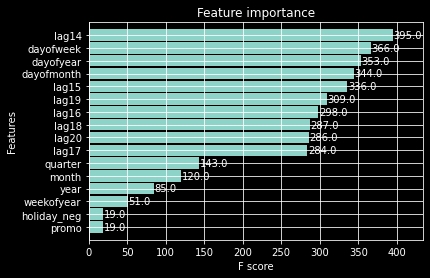

In [892]:
_ = xgb.plot_importance(xgb_model, height=.9)


### LOOP all stores

In [884]:
# LOOP all stores
xgb_result = pd.DataFrame()
for store in df_store['store_id'].unique():  # print(store)
    # get data
    y = df_store[df_store['store_id'] == store].set_index('date')['sales']/1e6

    # generate date-related features
    X = pd.DataFrame(index=y.index)
    X['dayofweek'] = X.index.dayofweek
    X['quarter'] = X.index.quarter
    X['month'] = X.index.month
    X['year'] = X.index.year
    X['dayofyear'] = X.index.dayofyear
    X['dayofmonth'] = X.index.day
    X['weekofyear'] = X.index.isocalendar().week.astype('int')

    # generate lag features
    # X['y'] = y
    min_lag = steps_ahead
    max_lag = steps_ahead + 7
    for lag in list(range(min_lag, max_lag)):
        X['lag' + str(lag)] = y.shift(lag)

    X = X.join(xgb_promo)
    X['promo'].fillna(False, inplace=True)

    # generate holiday features (negative impacts on sales)
    X = X.join(holiday_off.set_index('date').replace(1, True))
    X['holiday_neg'].fillna(False, inplace=True)

    # remove NAs
    X.dropna(inplace=True)
    y = y[max_lag-1:]

    # train/test splits
    y_train = y.iloc[:-steps_ahead]
    y_test = y.iloc[-steps_ahead:]
    X_train = X.iloc[:-steps_ahead]
    X_test = X.iloc[-steps_ahead:]

    # model
    xgb_model = xgb.XGBRegressor(n_estimators=1000)
    xgb_model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_test, y_test)],
                  early_stopping_rounds=50,
                  verbose=False)

    # forecast
    y_pred = pd.Series(xgb_model.predict(X_test), index=y_test.index)

    # metrics
    xgb_mae = round(mean_absolute_error(y_test, y_pred), 3)
    xgb_mape = round(mean_absolute_percentage_error(y_test, y_pred), 3)
    xgb_result = xgb_result.append({
        'store_id': store,
        'xgb_fc': y_pred,
        'xgb_mape': xgb_mape,
        'xgb_mae': xgb_mae,
    }, ignore_index=True)
# xgb_result.to_pickle('results/res_XGB.pkl')


In [885]:
y_pred

date
2021-01-18     7.181497
2021-01-19     5.199530
2021-01-20     5.260900
2021-01-21     5.491593
2021-01-22     3.462029
2021-01-23     7.126825
2021-01-24    12.641050
2021-01-25     4.549596
2021-01-26     4.802316
2021-01-27     4.903811
2021-01-28     3.723065
2021-01-29     3.923733
2021-01-30    11.300005
2021-01-31    11.114778
dtype: float32

In [886]:
xgb_result.mean()

store_id    394977.868421
xgb_mae          7.781447
xgb_mape         0.360368
dtype: float64

In [ ]:
xgb_result.mean()

store_id    394977.868421
xgb_mae          9.749026
xgb_mape         0.495737
dtype: float64

# result

In [744]:
res_ARIMA = pd.read_pickle('results/res_RW_ARIMA_whole_holiday_promo.pkl')
res_fb_noPromo = pd.read_pickle('results/res_fb_noPromo.pkl')
res_fb_withPromo = pd.read_pickle('results/res_fb_withPromo.pkl')
# xgb_result = pd.read_pickle('results/res_XGB.pkl')

# rename
res_ARIMA = res_ARIMA.rename({
    'fc_RW':'RW_fc',
    'RW_mae_OOS': 'RW_mae',
    'RW_mape_OOS': 'RW_mape',
    'fc_OOS': 'ARIMA_fc',
    'arima_mae_OOS': 'ARIMA_mae',
    'arima_mape_OOS': 'ARIMA_mape',
    }, axis=1).set_index('store_id')

# rearrange
res_ARIMA = res_ARIMA[[
    'RW_fc',
    'RW_mae',
    'RW_mape',
    'ARIMA_fc',
    'ARIMA_mae',
    'ARIMA_mape',
]]

# rename
res_fb_noPromo = res_fb_noPromo.rename({'fb_fc': 'FB_noPromo_fc',
                                        'fb_mae_OOS': 'FB_noPromo_mae',
                                        'fb_mape_OOS': 'FB_noPromo_mape'},axis=1).set_index('store_id')

# rename
res_fb_withPromo = res_fb_withPromo.rename({'fb_fc': 'FB_withPromo_fc',
                                        'fb_mae_OOS': 'FB_withPromo_mae',
                                        'fb_mape_OOS': 'FB_withPromo_mape'},axis=1).set_index('store_id')

# join
res = res_ARIMA.join([
    res_fb_noPromo,
    res_fb_withPromo,
    xgb_result.set_index('store_id')])
res.index = res.index.astype('int').astype('str')


### compare across stores

In [745]:
res_mape = res[['RW_mape', 'ARIMA_mape', 'FB_noPromo_mape', 'FB_withPromo_mape', 'xgb_mape']]
res_mape.plot()

In [746]:
res_mape.mean().sort_values()

FB_withPromo_mape    0.481579
FB_noPromo_mape      0.495474
xgb_mape             0.508053
ARIMA_mape           0.546842
RW_mape              0.624921
dtype: float64

### compare across horizons (1 store)

In [594]:
res_fc = res[['RW_fc','ARIMA_fc','FB_noPromo_fc','FB_withPromo_fc', 'xgb_fc']]
df_test = df_store.iloc[:,:3].set_index('date').pivot(columns='store_id', values='sales')[-steps_ahead:].T/1e6
df_test.index = df_test.index.astype('str')


In [602]:
# plot forecasts & true values

# store index
idx = df_test.index[0]
# idx = '307248'

true = df_test.loc[idx, :]
fc = res_fc.loc[idx, :]

fig = go.Figure()
# true data
fig.add_trace(
    go.Scatter(
        x=true.index,
        y=true,
        mode='lines', name='y_true', line=dict(color='black')
    ))
# forecast
for i in range(0, fc.shape[0]):
    fig.add_trace(
        go.Scatter(
            x=true.index,
            y=fc.iloc[i].values,
            mode='lines', name=res_fc.columns[i]),
    )
fig.show()


In [760]:
df_store.loc[df_store.store_id == int(idx), ['date','sales']].set_index('date').plot()